<a href="https://colab.research.google.com/github/majdsuleiman98/Sentiment-Analysis-of-Arabic-with-AraBERT-/blob/main/AraBertModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

In [ ]:
import os
import re
import random
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from transformers import AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import TensorDataset,random_split,DataLoader,RandomSampler

In [ ]:
data = pd.read_csv("/kaggle/input/arabic-company-reviews/CompanyReviews.csv")

In [ ]:
data.shape

(40046, 4)

In [ ]:
data.head()

,Unnamed: 0,review_description,rating,company
0,0,رائع,1,talbat
1,1,برنامج رائع جدا يساعد على تلبيه الاحتياجات بشك...,1,talbat
2,2,التطبيق لا يغتح دائما بيعطيني لا يوجد اتصال با...,-1,talbat
3,3,لماذا لا يمكننا طلب من ماكدونالدز؟,-1,talbat
4,4,البرنامج بيظهر كل المطاعم و مغلقه مع انها بتكو...,-1,talbat


In [ ]:
data.tail()

,Unnamed: 0,review_description,rating,company
40041,128,تجربه جيده بس ينقصها عدم اهتمام خدمة العملاء ب...,0,swvl
40042,129,انا ساكنة بمنطقة الكينج ولا توجد عربيات قبل ال...,-1,swvl
40043,130,جيد ولكن لماذا لا توجد خطوط كثيره من المريوطيه...,0,swvl
40044,131,جيدا جدا ...ولكن الاسعار عاليه جدا\n,0,swvl
40045,132,التطبيق حلو جدا والخدمه ممتازه ولكن الاسعار عا...,0,swvl


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40046 entries, 0 to 40045
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          40046 non-null  int64 
 1   review_description  40045 non-null  object
 2   rating              40046 non-null  int64 
 3   company             40046 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.2+ MB


In [ ]:
data.describe()

,Unnamed: 0,rating
count,40046.000000,40046.000000
mean,19521.781876,0.242746
std,11553.156518,0.945001
min,0.000000,-1.000000
25%,9506.250000,-1.000000
50%,19517.500000,1.000000
75%,29528.750000,1.000000
max,39540.000000,1.000000


In [ ]:
data.rating.value_counts()

rating
 1    23921
-1    14200
 0     1925
Name: count, dtype: int64

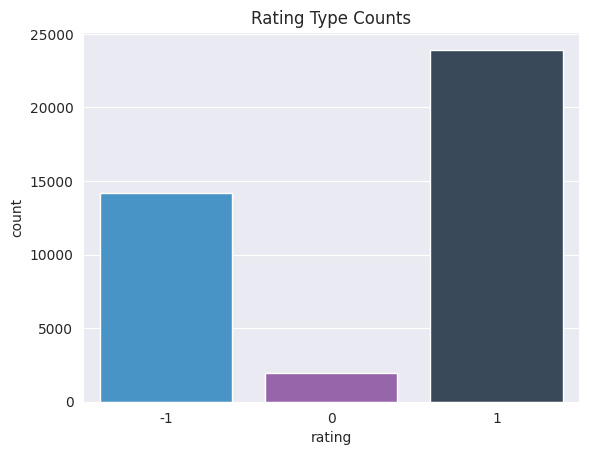

In [ ]:
sns.countplot(data=data,x=data['rating'],palette=['#3498db','#9b59b6','#34495e'])
plt.title('Rating Type Counts')
plt.show()

In [ ]:
def plot_distribution_length_of_sentences(data,col):
    lengths = [len(str(sent).split(' ')) for sent in data[col]]
    plt.figure(figsize=(8, 5))
    sns.set_style('darkgrid')
    sns.histplot(lengths, kde=True)
    plt.title('Sentences length histogram', fontsize=15, fontweight='bold')
    plt.xticks(fontweight='bold')
    plt.yticks(fontweight='bold')
    plt.xlabel('Length', fontweight='bold')
    plt.ylabel('Freaquency', fontweight='bold')
    plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


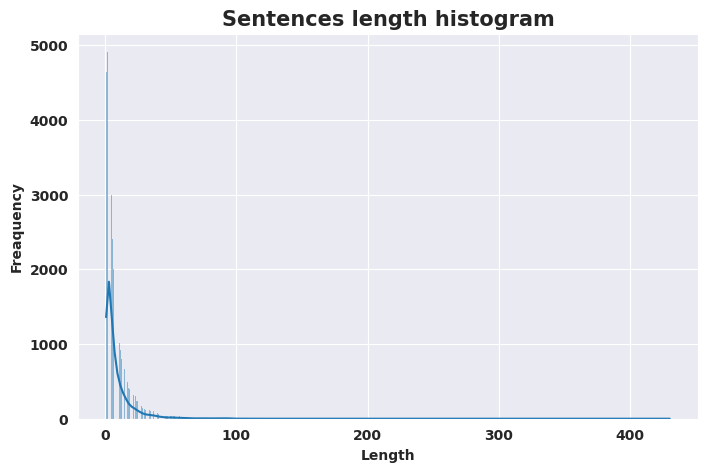

In [ ]:
plot_distribution_length_of_sentences(data,'review_description')

In [ ]:
data.isnull().sum()

Unnamed: 0            0
review_description    1
rating                0
company               0
dtype: int64

In [ ]:
data.dropna(inplace=True)

In [ ]:
data.shape

(40045, 4)

In [ ]:
data.duplicated().sum()

0

In [ ]:
!pip install arabic-reshaper
!pip install python-bidi
!pip install wordcloud

In [ ]:
from bidi.algorithm import get_display
from wordcloud import WordCloud
import arabic_reshaper

In [ ]:
font_path = '/kaggle/input/arabic-company-reviews/Amiri-Regular.ttf'
stopwords_path = '/kaggle/input/arabic-company-reviews/arabic_dialects_stopwords.csv'
stopwords = pd.read_csv(stopwords_path)["word"].tolist()
stopwords = [arabic_reshaper.reshape(s) for s in stopwords]
print(len(stopwords))
print(stopwords[:40])

1997
['?', 'ﻭﺫﻟﻚ', 'ﻭﻳﻌﻨﻲ', 'ﻭﺇﻳﺎﻛﻢ', 'ﻭﻭﻫﺬﺍ', 'ﺫﻱ', 'ﻫﻴﺎ', 'ﻭﺍﻟﻲ', 'ﻭﺃﻭﻟﺌﻚ', 'ﻟﻴﺴﺘﺎ', 'ﻟﻬﺎ', 'ﻭﻫﻲ', 'ﻳﺎﺀ', 'ﺇﺫﻥ', 'ﻭﺗﻴﻦ', 'ﻛﻴﻒ', 'ﻭﻷﻥ', 'ﻭﺧﺎﺀ', 'ﺗﻔﻌﻠﻴﻦ', 'ﺭﺏ', 'ﻭﺑﻞ', 'ﻭﻣﻮ', 'ﻭﺍ', 'ﺃﺿﺤﻰ', 'ﺍﻛﺘﻮﺑﺮ', 'ﺳﻮﻯ', 'ﺃ', 'ﻭﻣﺎ ﺍﻧﻔﻚ', 'ﺍﻷﻟﻰ', 'ﻭﻓﺎﻧﻪ', 'ﻭﺍﻥ', 'ﻭﺟﻠﻞ', 'ﻣﺎ ﺍﻧﻔﻚ', 'ﻭﺁﻧﻔﺎ', 'ﻭﺍﻧﻪ', 'ﻭﺣﻴﻦ', 'ﺍﻋﺎﺩﺓ', 'ﻭﺍﻻﻟﻰ', 'ﻧﺒﺎ', 'ﺃﻣﺎﻡ']


In [ ]:
def column_to_wordcloud(df, column, font_path):
    reshaped_texts = []

    # Ensure that the column contains only valid strings and process them
    valid_texts = df[column].dropna().astype(str).tolist()

    for text in valid_texts:
        try:
            reshaped_text = arabic_reshaper.reshape(text)
            reshaped_texts.append(reshaped_text)
        except IndexError:
            print(f"Error reshaping text: {text}")
            continue  # Skip this text if there's an issue reshaping it

    # Join all reshaped texts into one large string
    reshaped_text = " ".join(reshaped_texts)

    # Create the word cloud
    wordcloud = WordCloud(
        font_path=font_path,
        width=800,
        height=400,
        background_color='white',
        collocations=False,
        stopwords=stopwords
    ).generate(reshaped_text)

    # Display the word cloud
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


In [ ]:
def data_cleaning(text):
    clean = text

    # Replace consecutive dots with an empty string
    pattern = re.compile(r'\.+?(?=\B|$)')
    clean = clean.apply(lambda r: re.sub(pattern, '', r))

    # Replace '\x89Û_' with a whitespace
    pattern = re.compile(r'\x89Û_')
    clean = clean.apply(lambda r: re.sub(pattern, ' ', r))

    # Replace '&amp' with '&'
    pattern = re.compile(r'\&amp')
    clean = clean.apply(lambda r: re.sub(pattern, '&', r))

    # Replace newline characters with a whitespace
    pattern = re.compile(r'\n')
    clean = clean.apply(lambda r: re.sub(pattern, ' ', r))

    # Remove '#' symbol from text
    clean = clean.apply(lambda r: r.replace('#', ''))

    # Replace usernames with '@'
    pattern = re.compile(r'@[a-zA-Z0-9_]+')
    clean = clean.apply(lambda r: re.sub(pattern, '@', r))

    # Remove URLs
    pattern = re.compile(r'https?\S+(?=\s|$)')
    clean = clean.apply(lambda r: re.sub(pattern, 'www', r))

    # Remove non-alphanumeric characters (icons and special characters)
    pattern = re.compile(r'[^\w\s@]')
    clean = clean.apply(lambda r: re.sub(pattern, '', r))

    # Convert text to lowercase
    clean = clean.apply(lambda r: r.lower())

    # Remove extra whitespaces
    clean = clean.apply(lambda r: ' '.join(r.split()))

    return clean


In [ ]:
data['review_description'] = data_cleaning(data['review_description'])

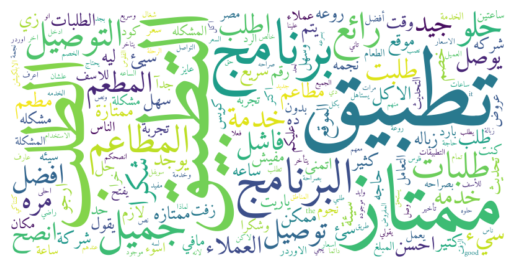

In [ ]:
column_to_wordcloud(data,'review_description',font_path)

In [ ]:
df = data[data['rating'] != 0 ]
df.reset_index(drop=True, inplace=True)

In [ ]:
df.shape

(38120, 4)

In [ ]:
df.head()

,Unnamed: 0,review_description,rating,company
0,0,رائع,1,talbat
1,1,برنامج رائع جدا يساعد على تلبيه الاحتياجات بشك...,1,talbat
2,2,التطبيق لا يغتح دائما بيعطيني لا يوجد اتصال با...,-1,talbat
3,3,لماذا لا يمكننا طلب من ماكدونالدز,-1,talbat
4,4,البرنامج بيظهر كل المطاعم و مغلقه مع انها بتكو...,-1,talbat


In [ ]:
df.tail()

,Unnamed: 0,review_description,rating,company
38115,115,الابليكيشن يدخلنا فى متاهات لا نفهم منها شيء ا...,-1,swvl
38116,116,تجربة سيئة جدا منصحش اى حد بتحميل التطبيق النظ...,-1,swvl
38117,122,بعد ما اخدت الباقة الاولى ب ١٦٠ جنيه ٣٠ رحلة ب...,-1,swvl
38118,124,الخدمة جيدة ولكن يرجى تعديل سلوك بعض السائقين,1,swvl
38119,129,انا ساكنة بمنطقة الكينج ولا توجد عربيات قبل ال...,-1,swvl


In [ ]:
df.rating.value_counts()

rating
 1    23921
-1    14199
Name: count, dtype: int64

In [ ]:
X = df['review_description']
y = df['rating']

In [ ]:
encode = {1:1,-1:0}
y = y.map(encode)

In [ ]:
X.head()

0                                                 رائع
1    برنامج رائع جدا يساعد على تلبيه الاحتياجات بشك...
2    التطبيق لا يغتح دائما بيعطيني لا يوجد اتصال با...
3                    لماذا لا يمكننا طلب من ماكدونالدز
4    البرنامج بيظهر كل المطاعم و مغلقه مع انها بتكو...
Name: review_description, dtype: object

In [ ]:
y.head()

0    1
1    1
2    0
3    0
4    0
Name: rating, dtype: int64

In [ ]:
X = X.values
y = y.values

In [ ]:
print(len(X),len(y))
print(X[4],y[4])

38120 38120
البرنامج بيظهر كل المطاعم و مغلقه مع انها بتكون فاتحه بقاله كده اكتر من شهر 0


In [ ]:
model_name = 'aubmindlab/bert-base-arabertv02'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
tokenizer.vocab

{'لإقرار': 25468,
 'بخفة': 58690,
 'وفاع': 16327,
 '[UNUSED_647]': 60647,
 'تشغيل': 6276,
 'ناص': 16121,
 '[UNUSED_1853]': 61853,
 'ونسي': 57519,
 '##لتزم': 26446,
 'مشاع': 19348,
 'بتأهيل': 50262,
 '##رى': 851,
 'بشرعية': 45003,
 'اللفظي': 50813,
 'وبانتظار': 58745,
 'التخرج': 18396,
 'وبدل': 37788,
 'نافذا': 46870,
 '[UNUSED_354]': 60354,
 'هللة': 49640,
 'يمتد': 12531,
 'أكرم': 20206,
 'وظيفته': 23470,
 'الإعلامية': 5803,
 'بإلغاء': 12941,
 'براين': 50565,
 'قابس': 31022,
 '##واعير': 54549,
 'الاملاك': 50471,
 'وابرزها': 59984,
 '##Y': 271,
 'اتهامات': 10062,
 'يعلمها': 58611,
 'كرة': 2460,
 'باعت': 2912,
 'لإنهاء': 11189,
 'فط': 22135,
 'بشبكة': 24043,
 'ومط': 19636,
 'اللاسلكي': 43249,
 'بوب': 15557,
 'منافس': 21874,
 '[UNUSED_1616]': 61616,
 'جانبه': 3262,
 'رواه': 32316,
 'وإنارة': 49860,
 'قراءات': 36140,
 'لمصلحتهم': 59138,
 'أبريل': 4557,
 '##يستا': 47943,
 'حشاد': 59245,
 'زع': 7366,
 '##يطالية': 6242,
 'الشق': 18275,
 '##وتات': 32019,
 'محسوب': 39143,
 '[UNUSED_136]': 60136

In [ ]:
print(X[1])
print(tokenizer.tokenize(X[1]))
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(X[1])))

برنامج رائع جدا يساعد على تلبيه الاحتياجات بشكل اسرع
['برنامج', 'رائع', 'جدا', 'يساعد', 'على', 'تلبي', '##ه', 'الاحتياجات', 'بشكل', 'اسرع']
[1671, 13149, 1626, 5845, 323, 17967, 195, 6656, 980, 26389]


In [ ]:
input_ids = list()
attention_masks = list()

for sent in X:
    encode_dict = tokenizer.encode_plus(
        sent,
        add_special_tokens=True, #add [CLS] and [SEP]
        max_length=32,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids.append(encode_dict['input_ids'])
    attention_masks.append(encode_dict['attention_mask'])

In [ ]:
len(input_ids),len(attention_masks),len(input_ids[0][0])

(38120, 38120, 32)

In [ ]:
ss = np.array(input_ids)
ss.shape

(38120, 1, 32)

In [ ]:
input_ids = torch.cat(input_ids,dim=0)
attention_masks = torch.cat(attention_masks,dim=0)
input_ids.shape,attention_masks.shape

(torch.Size([38120, 32]), torch.Size([38120, 32]))

In [ ]:
print(X[1])
print(tokenizer.tokenize(X[1]))
print(input_ids[1])
print(attention_masks[1])

برنامج رائع جدا يساعد على تلبيه الاحتياجات بشكل اسرع
['برنامج', 'رائع', 'جدا', 'يساعد', 'على', 'تلبي', '##ه', 'الاحتياجات', 'بشكل', 'اسرع']
tensor([    2,  1671, 13149,  1626,  5845,   323, 17967,   195,  6656,   980,
        26389,     3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


In [ ]:
y = torch.tensor(y)

In [ ]:
print(type(input_ids), input_ids.shape)
print(type(attention_masks), attention_masks.shape)
print(type(y), y.shape)

<class 'torch.Tensor'> torch.Size([38120, 32])
<class 'torch.Tensor'> torch.Size([38120, 32])
<class 'torch.Tensor'> torch.Size([38120])


In [ ]:
dataset = TensorDataset(input_ids,attention_masks,y)

In [ ]:
len(dataset)

38120

In [ ]:
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_size,val_size

(34308, 3812)

In [ ]:
train_dataset, val_dataset = random_split(dataset,[train_size,val_size])

In [ ]:
len(train_dataset),len(val_dataset)

(34308, 3812)

In [ ]:
train_dataset[0]

(tensor([    2,  1671, 59205,  1626,  9687,  1074,  1330, 37407,  1439,   448,
         58987,  9417,   233,   132,  3980,     3,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]),
 tensor(0))

In [ ]:
val_dataset[0]

(tensor([    2,  1671,   352,  1958, 16319,  4885,  9698,  3857,   195,  5529,
         39491,  6796,   323, 16862,     3,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]),
 tensor(1))

In [ ]:
batch_size = 32
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, sampler=RandomSampler(val_dataset), batch_size=batch_size)

In [ ]:
len(train_dataloader), len(val_dataloader)

(1073, 120)

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    output_attentions = False,
    output_hidden_states = False,
)

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
device

device(type='cuda')

In [ ]:
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(64000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
optimizer = AdamW(model.parameters(),lr = 2e-5, eps = 1e-8 )

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps = 0, num_training_steps = total_steps)

In [ ]:
def flat_accuracy(preds,labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)




training_stats = []


for epoch_i in tqdm(range(0, epochs)):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    total_train_loss = 0
    model.train()
    for step, batch in tqdm(enumerate(train_dataloader)):
        if step % 40 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()

        result = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)


    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))

    print("")
    print("Running Validation...")

    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in tqdm(val_dataloader):

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():
            result = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        loss = result.loss
        logits = result.logits
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(val_dataloader)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
        }
    )

  0%|          | 0/5 [00:00<?, ?it/s]


======== Epoch 1 / 5 ========
Training...


0it [00:00, ?it/s]

  Batch    40  of  1,073.
  Batch    80  of  1,073.
  Batch   120  of  1,073.
  Batch   160  of  1,073.
  Batch   200  of  1,073.
  Batch   240  of  1,073.
  Batch   280  of  1,073.
  Batch   320  of  1,073.
  Batch   360  of  1,073.
  Batch   400  of  1,073.
  Batch   440  of  1,073.
  Batch   480  of  1,073.
  Batch   520  of  1,073.
  Batch   560  of  1,073.
  Batch   600  of  1,073.
  Batch   640  of  1,073.
  Batch   680  of  1,073.
  Batch   720  of  1,073.
  Batch   760  of  1,073.
  Batch   800  of  1,073.
  Batch   840  of  1,073.
  Batch   880  of  1,073.
  Batch   920  of  1,073.
  Batch   960  of  1,073.
  Batch 1,000  of  1,073.
  Batch 1,040  of  1,073.

  Average training loss: 0.17

Running Validation...


  0%|          | 0/120 [00:00<?, ?it/s]

  Accuracy: 0.90
  Validation Loss: 0.27

======== Epoch 2 / 5 ========
Training...


0it [00:00, ?it/s]

  Batch    40  of  1,073.
  Batch    80  of  1,073.
  Batch   120  of  1,073.
  Batch   160  of  1,073.
  Batch   200  of  1,073.
  Batch   240  of  1,073.
  Batch   280  of  1,073.
  Batch   320  of  1,073.
  Batch   360  of  1,073.
  Batch   400  of  1,073.
  Batch   440  of  1,073.
  Batch   480  of  1,073.
  Batch   520  of  1,073.
  Batch   560  of  1,073.
  Batch   600  of  1,073.
  Batch   640  of  1,073.
  Batch   680  of  1,073.
  Batch   720  of  1,073.
  Batch   760  of  1,073.
  Batch   800  of  1,073.
  Batch   840  of  1,073.
  Batch   880  of  1,073.
  Batch   920  of  1,073.
  Batch   960  of  1,073.
  Batch 1,000  of  1,073.
  Batch 1,040  of  1,073.

  Average training loss: 0.18

Running Validation...


  0%|          | 0/120 [00:00<?, ?it/s]

  Accuracy: 0.91
  Validation Loss: 0.27

======== Epoch 3 / 5 ========
Training...


0it [00:00, ?it/s]

  Batch    40  of  1,073.
  Batch    80  of  1,073.
  Batch   120  of  1,073.
  Batch   160  of  1,073.
  Batch   200  of  1,073.
  Batch   240  of  1,073.
  Batch   280  of  1,073.
  Batch   320  of  1,073.
  Batch   360  of  1,073.
  Batch   400  of  1,073.
  Batch   440  of  1,073.
  Batch   480  of  1,073.
  Batch   520  of  1,073.
  Batch   560  of  1,073.
  Batch   600  of  1,073.
  Batch   640  of  1,073.
  Batch   680  of  1,073.
  Batch   720  of  1,073.
  Batch   760  of  1,073.
  Batch   800  of  1,073.
  Batch   840  of  1,073.
  Batch   880  of  1,073.
  Batch   920  of  1,073.
  Batch   960  of  1,073.
  Batch 1,000  of  1,073.
  Batch 1,040  of  1,073.

  Average training loss: 0.14

Running Validation...


  0%|          | 0/120 [00:00<?, ?it/s]

  Accuracy: 0.90
  Validation Loss: 0.31

======== Epoch 4 / 5 ========
Training...


0it [00:00, ?it/s]

  Batch    40  of  1,073.
  Batch    80  of  1,073.
  Batch   120  of  1,073.
  Batch   160  of  1,073.
  Batch   200  of  1,073.
  Batch   240  of  1,073.
  Batch   280  of  1,073.
  Batch   320  of  1,073.
  Batch   360  of  1,073.
  Batch   400  of  1,073.
  Batch   440  of  1,073.
  Batch   480  of  1,073.
  Batch   520  of  1,073.
  Batch   560  of  1,073.
  Batch   600  of  1,073.
  Batch   640  of  1,073.
  Batch   680  of  1,073.
  Batch   720  of  1,073.
  Batch   760  of  1,073.
  Batch   800  of  1,073.
  Batch   840  of  1,073.
  Batch   880  of  1,073.
  Batch   920  of  1,073.
  Batch   960  of  1,073.
  Batch 1,000  of  1,073.
  Batch 1,040  of  1,073.

  Average training loss: 0.12

Running Validation...


  0%|          | 0/120 [00:00<?, ?it/s]

  Accuracy: 0.90
  Validation Loss: 0.35

======== Epoch 5 / 5 ========
Training...


0it [00:00, ?it/s]

  Batch    40  of  1,073.
  Batch    80  of  1,073.
  Batch   120  of  1,073.
  Batch   160  of  1,073.
  Batch   200  of  1,073.
  Batch   240  of  1,073.
  Batch   280  of  1,073.
  Batch   320  of  1,073.
  Batch   360  of  1,073.
  Batch   400  of  1,073.
  Batch   440  of  1,073.
  Batch   480  of  1,073.
  Batch   520  of  1,073.
  Batch   560  of  1,073.
  Batch   600  of  1,073.
  Batch   640  of  1,073.
  Batch   680  of  1,073.
  Batch   720  of  1,073.
  Batch   760  of  1,073.
  Batch   800  of  1,073.
  Batch   840  of  1,073.
  Batch   880  of  1,073.
  Batch   920  of  1,073.
  Batch   960  of  1,073.
  Batch 1,000  of  1,073.
  Batch 1,040  of  1,073.

  Average training loss: 0.11

Running Validation...


  0%|          | 0/120 [00:00<?, ?it/s]

  Accuracy: 0.90
  Validation Loss: 0.35


In [ ]:
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.
epoch,,,
1,0.166058,0.270100,0.900000
2,0.181833,0.267968,0.905990
3,0.144555,0.309601,0.900781
4,0.118270,0.346301,0.901042
5,0.106288,0.346286,0.901042


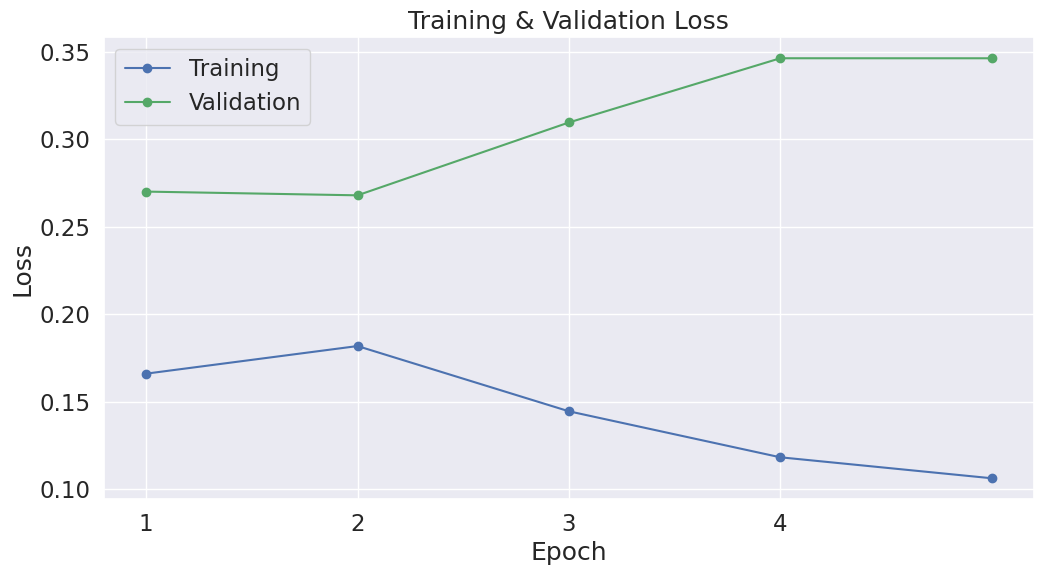

In [ ]:
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])
plt.show()

In [ ]:
def predict_class(test_sent):
    encoded_dict = tokenizer.encode_plus(
                        test_sent,
                        add_special_tokens = True,
                        max_length = 32,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    test_input_ids = encoded_dict['input_ids']
    test_attention_masks = encoded_dict['attention_mask']

    model.eval()
    with torch.no_grad():

        test_input_ids = test_input_ids.to(device)
        test_attention_masks = test_attention_masks.to(device)
        result = model(test_input_ids,
                     token_type_ids=None,
                     attention_mask=test_attention_masks,
                     return_dict=True)
        logits = result.logits
        predicted_class = torch.argmax(logits, dim=1)
        predicted_class_list = predicted_class.cpu().numpy().tolist()


    print(result)
    print(predicted_class)
    print(predicted_class_list)
    if predicted_class_list[0] == 0:
        print('This is a negative comment')
    elif predicted_class_list[0] ==1:
        print('This is a positive comment')
    else:
        print('None')

In [ ]:
predict_class('منتج سيء')

SequenceClassifierOutput(loss=None, logits=tensor([[ 2.7905, -2.2829]], device='cuda:0'), hidden_states=None, attentions=None)
tensor([0], device='cuda:0')
[0]
This is a negative comment


In [ ]:
predict_class('روعة بصراحة')

SequenceClassifierOutput(loss=None, logits=tensor([[-2.2779,  2.3819]], device='cuda:0'), hidden_states=None, attentions=None)
tensor([1], device='cuda:0')
[1]
This is a positive comment


In [ ]:
predict_class('حبيت مرة سهل الاستخدام')

SequenceClassifierOutput(loss=None, logits=tensor([[-2.8912,  2.7969]], device='cuda:0'), hidden_states=None, attentions=None)
tensor([1], device='cuda:0')
[1]
This is a positive comment


In [ ]:
predict_class('يوجد فيه مشاكل')

SequenceClassifierOutput(loss=None, logits=tensor([[ 2.9211, -2.6009]], device='cuda:0'), hidden_states=None, attentions=None)
tensor([0], device='cuda:0')
[0]
This is a negative comment


In [ ]:
# Save the model
torch.save(model.state_dict(), '/kaggle/working/model.pth')